In [97]:
# conda deactivate
# source ros

# OR conda activate ros2

import os
import argparse
from rclpy.serialization import deserialize_message
from rosidl_runtime_py.utilities import get_message
from std_msgs.msg import String
import rosbag2_py
from mcap.reader import make_reader
from mcap_protobuf.decoder import DecoderFactory
from nuscenes.nuscenes import NuScenes
import numpy as np
import matplotlib.pyplot as plt
import gtsam
from functools import partial
from typing import List, Optional
import pandas as pd

# Traverse all files

In [98]:
mcap_path = '/home/jd/nuscenes2mcap/output'

In [99]:
# Iterate through mcap files and write detections
for root, _,files in os.walk(mcap_path,topdown=True):
    for file in files:

        # Get input filepath
        in_file = os.path.join(root,file)
        print(in_file)

/home/jd/nuscenes2mcap/output/NuScenes-v1.0-mini-scene-1077-megvii.mcap
/home/jd/nuscenes2mcap/output/NuScenes-v1.0-mini-scene-0553-megvii.mcap
/home/jd/nuscenes2mcap/output/NuScenes-v1.0-mini-scene-1100-megvii.mcap
/home/jd/nuscenes2mcap/output/NuScenes-v1.0-mini-scene-1094-megvii.mcap
/home/jd/nuscenes2mcap/output/NuScenes-v1.0-mini-scene-0061-megvii.mcap
/home/jd/nuscenes2mcap/output/NuScenes-v1.0-mini-scene-0655-megvii.mcap
/home/jd/nuscenes2mcap/output/NuScenes-v1.0-mini-scene-0796-megvii.mcap
/home/jd/nuscenes2mcap/output/NuScenes-v1.0-mini-scene-0103-megvii.mcap
/home/jd/nuscenes2mcap/output/NuScenes-v1.0-mini-scene-0757-megvii.mcap
/home/jd/nuscenes2mcap/output/NuScenes-v1.0-mini-scene-0916-megvii.mcap


# Examine a single file

In [100]:
in_file = '/home/jd/nuscenes2mcap/output/NuScenes-v1.0-mini-scene-0061-megvii.mcap'
topics=['/markers/annotations','/markers/detections']
data_dir = '/home/jd/nuscenes/data'
name="v1.0-mini"

nusc = NuScenes(version=name, dataroot=str(data_dir), verbose=True)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.407 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


In [156]:
# REORDER INTO DICT INDEXED BY OBJECT, not as mcap indexed by time...

reader = make_reader(open(in_file, 'br'), decoder_factories=[DecoderFactory()])

epoch = 0
t = dict()
objects = dict()

for schema, channel, message, msg in reader.iter_decoded_messages(topics=topics):
        
    if channel.topic =='/markers/annotations':
#         print("Annotation step: " + str(annotation_count))
        
        # Get timestamp for this epoch
        tstamp = msg.entities[0].timestamp
        if tstamp not in t.values():
            t[epoch] = tstamp
            epoch+=1
        
        
        # For each actual annotation in the message


        # Get epoch from timestamp
        current_epoch = list(t.keys())[list(t.values()).index(tstamp)]       
        
        for entity in msg.entities:
            # Get entity data
            obj_id = entity.id
            
            # Get spatial data
            pos = entity.cubes[0].pose.position
            rot = entity.cubes[0].pose.orientation
            size = entity.cubes[0].size
            
            # Get semantic data
            cat = entity.metadata[0].value
            attribute = nusc.get('attribute',entity.metadata[1].value)['name'] if entity.metadata[1].value else ''
            
            # Initialize dict entry for this object if not done already
            if obj_id not in objects.keys():
                objects[obj_id] = dict()
                objects[obj_id]['category'] = cat
                objects[obj_id]['states'] = dict()
          
            objects[obj_id]['states'][current_epoch] = {
                    "stamp": tstamp,
                    "pos": pos,
                    "rot": rot,
                    "size": size,
                    "att": attribute
                }


In [157]:
print(objects[obj_id])

{'category': 'movable_object.trafficcone', 'states': {37: {'stamp': seconds: 1532402946
nanos: 297085000
, 'pos': x: 453.388
y: 1088.275
z: 0.395
, 'rot': z: 0.97655970930480041
w: 0.21524668211734141
, 'size': x: 0.578
y: 0.582
z: 0.844
, 'att': ''}, 38: {'stamp': seconds: 1532402946
nanos: 797517000
, 'pos': x: 453.386
y: 1088.271
z: 0.495
, 'rot': z: 0.97655970930480041
w: 0.21524668211734141
, 'size': x: 0.578
y: 0.582
z: 0.844
, 'att': ''}}}


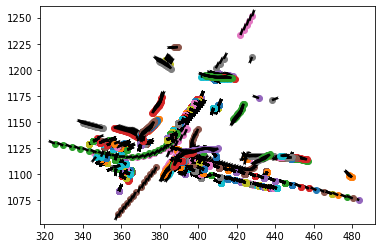

In [103]:
for key in objects:
    obj = objects[key]

    x = np.zeros(len(obj['states']))
    y = np.zeros(len(obj['states']))
    dxx = np.zeros(len(obj['states']))
    dxy = np.zeros(len(obj['states']))
    dyx = np.zeros(len(obj['states']))
    dyy = np.zeros(len(obj['states']))
    theta = np.zeros(len(obj['states']))

    ii=0
    for state in obj['states']:
        
        x[ii] = obj['states'][state]['pos'].x
        y[ii] = obj['states'][state]['pos'].y
        theta[ii] = 2*np.arccos(obj['states'][state]['rot'].w)
        dxx[ii] = np.cos(theta[ii])
        dxy[ii] = np.sin(theta[ii])
        dyx[ii] = -np.sin(theta[ii])
        dyy[ii] = np.cos(theta[ii])
        ii+=1

    plt.scatter(x,y)
    plt.quiver(x,y,dxx,dxy,headwidth=0)
    # plt.quiver(x,y,dyx,dyy)
    
plt.show()


# GTSAM stuff

In [104]:
def const_pos_error(constants, this: gtsam.CustomFactor,
               values: gtsam.Values,
               jacobians: Optional[List[np.ndarray]]) -> np.ndarray:

    # Get position annotation
    state = constants[0]
    p = gtsam.Point3(state['pos'].x,state['pos'].y,state['pos'].z)
    
    # Get variable values
    pos_key = this.keys()[0]
    pos = values.atVector(pos_key)
        
    # Compute error
    error = pos - p
    
    if jacobians is not None:
        jacobians[0] = np.eye(3)

    return error


def vel_dyn_const_error(constants, this: gtsam.CustomFactor,
               values: gtsam.Values,
               jacobians: Optional[List[np.ndarray]]) -> np.ndarray:

    last_state = constants[0]
    state = constants[1]

    # Extract constants from state
    last_p = gtsam.Point3(last_state['pos'].x,last_state['pos'].y,last_state['pos'].z)
    p = gtsam.Point3(state['pos'].x,state['pos'].y,state['pos'].z)
    dt = (state['stamp'].seconds + state['stamp'].nanos/10**9) - (last_state['stamp'].seconds + last_state['stamp'].nanos/10**9)
    
    #######
    R = gtsam.Rot3(state['rot'].w,state['rot'].x,state['rot'].y,state['rot'].z)
    last_R = gtsam.Rot3(last_state['rot'].w,last_state['rot'].x,last_state['rot'].y,last_state['rot'].z)    
    
    # Get variable values
    last_vel_key = this.keys()[0]
    vel_key = this.keys()[1]
    last_vel, vel = values.atVector(last_vel_key), values.atVector(vel_key)
        
    # Compute error
    #error = (p - (last_p + dt*(last_vel + vel)/2)) 
    error = (p - (last_p + dt*(last_R.rotate(last_vel) + R.rotate(vel))/2)) 
    
    if jacobians is not None:
#         jacobians[0] = -np.eye(3)*dt/2 # last vel
#         jacobians[1] = -np.eye(3)*dt/2 # vel
        jacobians[0] = -last_R.matrix()*dt/2 # last vel
        jacobians[1] = -R.matrix()*dt/2 # vel
    return error

def vel_eq_error(this: gtsam.CustomFactor,
               values: gtsam.Values,
               jacobians: Optional[List[np.ndarray]]) -> np.ndarray:

    # Get variable values
    last_vel_key = this.keys()[0]
    vel_key = this.keys()[1]
    last_vel, vel = values.atVector(last_vel_key), values.atVector(vel_key)
        
    # Compute error
    error = last_vel - vel
    
    if jacobians is not None:
        jacobians[0] = np.eye(3) # last vel
        jacobians[1] = -np.eye(3) # vel

    return error

def acc_dyn_const_error(constants, this: gtsam.CustomFactor,
               values: gtsam.Values,
               jacobians: Optional[List[np.ndarray]]) -> np.ndarray:

    last_state = constants[0]
    state = constants[1]

    # Extract constants from state
    dt = (state['stamp'].seconds + state['stamp'].nanos/10**9) - (last_state['stamp'].seconds + last_state['stamp'].nanos/10**9)
    
    # Get variable values
    last_vel_key = this.keys()[0]
    vel_key = this.keys()[1]
    last_vel, vel = values.atVector(last_vel_key), values.atVector(vel_key)
    
    last_acc_key = this.keys()[2]
    acc_key = this.keys()[3]
    last_acc, acc = values.atVector(last_acc_key), values.atVector(acc_key)
        
    # Compute error
    error = (vel - (last_vel + dt*(last_acc + acc)/2)) 
    
    if jacobians is not None:
        jacobians[0] = -np.eye(3) # last vel
        jacobians[1] = np.eye(3) # vel
        jacobians[2] = -np.eye(3)*dt/2 # last acc
        jacobians[3] = -np.eye(3)*dt/2 # acc

    return error

def acc_eq_error(this: gtsam.CustomFactor,
               values: gtsam.Values,
               jacobians: Optional[List[np.ndarray]]) -> np.ndarray:

    # Get variable values
    last_acc_key = this.keys()[0]
    acc_key = this.keys()[1]
    last_acc, acc = values.atVector(last_acc_key), values.atVector(acc_key)
        
    # Compute error
    error = last_acc - acc
    
    if jacobians is not None:
        jacobians[0] = np.eye(3) # last acc
        jacobians[1] = -np.eye(3) # acc

    return error

def omega_dyn_const_error(constants, this: gtsam.CustomFactor,
               values: gtsam.Values,
               jacobians: Optional[List[np.ndarray]]) -> np.ndarray:

    last_state = constants[0]
    state = constants[1]

    # Extract constants from state
    last_theta = gtsam.Point3(0,0,2*np.arccos(last_state['rot'].w))
    theta = gtsam.Point3(0,0,2*np.arccos(state['rot'].w))
    dt = (state['stamp'].seconds + state['stamp'].nanos/10**9) - (last_state['stamp'].seconds + last_state['stamp'].nanos/10**9)
    
    # Get variable values
    last_omega_key = this.keys()[0]
    omega_key = this.keys()[1]
    last_omega, omega = values.atVector(last_omega_key), values.atVector(omega_key)
        
    # Compute error
    error = (theta - (last_theta + dt*(last_omega + omega)/2))
    
    if jacobians is not None:
        jacobians[0] = -np.eye(3) # last acc
        jacobians[1] = -np.eye(3) # acc

    return error

In [146]:
# create the graph and solver
graph = gtsam.NonlinearFactorGraph()
unit_noise = gtsam.noiseModel.Diagonal.Sigmas(gtsam.Point3(1,1,1))
init_values = gtsam.Values()

# Initialize graph variable indices
var_idx = 0

# for each object in objects / get object
for key in objects:
    obj = objects[key]
    print()
    print('KEY IS')
    print(key)

    if key in ['ac26']:
        continue
    
    if obj['category'] not in ['human.pedestrian.adult','human.pedestrian.construction_worker','movable_object.trafficcone','movable_object.barrier','movable_object.pushable_pullable','movable_object.debris']:
        print("AAAAAAAAAAAAAAAAAAAAAA******************")
        print(obj['category'])
        continue
    
    
    # STATIC OBJECT / constant position
    if obj['category'] in ['movable_object.trafficcone','movable_object.barrier','movable_object.pushable_pullable','movable_object.debris']:
        print('static')
        print(var_idx)
        init_values.insert(gtsam.symbol('p',var_idx),gtsam.Point3(0,0,0))

        # iterate through states in object, add to graph 
        for key in list(obj['states']):
            obj['states'][key]['p_sym'] = gtsam.symbol('p',var_idx)
            const_pos_factor= gtsam.CustomFactor(unit_noise,[gtsam.symbol('p',var_idx)],partial(const_pos_error, [obj['states'][key]]))
            graph.add(const_pos_factor)
            
        var_idx+=1    
    
    
    # DYNAMIC OBJECT
    if obj['category'] in ['human.pedestrian.adult','human.pedestrian.construction_worker']:
        print('dynamic')
        # iterate through states in object, add to graph
        
        if len(obj['states'])==2:
            print('len 2')
            print(var_idx)

            # First trajectory element
            if key == list(obj['states'])[0]:
                print('first key')
                # Add variables 
                init_values.insert(gtsam.symbol('v',var_idx),gtsam.Point3(0,0,0))
                init_values.insert(gtsam.symbol('w',var_idx),gtsam.Point3(0,0,0))
                init_values.insert(gtsam.symbol('a',var_idx),gtsam.Point3(0,0,0))
                obj['states'][key]['v_sym'] = gtsam.symbol('v',var_idx)
                obj['states'][key]['w_sym'] = gtsam.symbol('w',var_idx)
                obj['states'][key]['a_sym'] = gtsam.symbol('a',var_idx)

                # Increment keys and indices
                last_key = key
                last_var_idx = var_idx
                var_idx+=1

            # Last trajectory element
            else:
                print('last key')

                # Add variables from this state
                init_values.insert(gtsam.symbol('v',var_idx),gtsam.Point3(0,0,0))
                init_values.insert(gtsam.symbol('w',var_idx),gtsam.Point3(0,0,0))
                init_values.insert(gtsam.symbol('a',var_idx),gtsam.Point3(0,0,0))
                obj['states'][key]['v_sym'] = gtsam.symbol('v',var_idx)
                obj['states'][key]['w_sym'] = gtsam.symbol('w',var_idx)
                obj['states'][key]['a_sym'] = gtsam.symbol('a',var_idx)

                # Add Dynamics constraints
                vel_dyn_const= gtsam.CustomFactor(unit_noise,[gtsam.symbol('v',last_var_idx),gtsam.symbol('v',var_idx)],partial(vel_dyn_const_error, [obj['states'][last_key],obj['states'][key]]))
                graph.add(vel_dyn_const)
                acc_dyn_const= gtsam.CustomFactor(unit_noise,[gtsam.symbol('v',last_var_idx),gtsam.symbol('v',var_idx),gtsam.symbol('a',last_var_idx),gtsam.symbol('a',var_idx)],partial(acc_dyn_const_error, [obj['states'][last_key],obj['states'][key]]))
                graph.add(acc_dyn_const)
                omega_dyn_const= gtsam.CustomFactor(unit_noise,[gtsam.symbol('w',last_var_idx),gtsam.symbol('w',var_idx)],partial(omega_dyn_const_error, [obj['states'][last_key],obj['states'][key]]))
                graph.add(omega_dyn_const)

                # Add equality constraints
                vel_eq_const = gtsam.CustomFactor(unit_noise,[gtsam.symbol('v',last_var_idx),gtsam.symbol('v',var_idx)],partial(vel_eq_error))
                graph.add(vel_eq_const)
                acc_eq_const = gtsam.CustomFactor(unit_noise,[gtsam.symbol('a',last_var_idx),gtsam.symbol('a',var_idx)],partial(acc_eq_error))
                graph.add(acc_eq_const)
                omega_eq_const = gtsam.CustomFactor(unit_noise,[gtsam.symbol('w',last_var_idx),gtsam.symbol('w',var_idx)],partial(vel_eq_error))
                graph.add(omega_eq_const)

                # Increment counters
                last_key = key
                last_var_idx = var_idx
                var_idx+=1    
        
        else:
            print('len >2')
            for key in list(obj['states']):

                print(var_idx)

                # First trajectory element
                if key == list(obj['states'])[0]:
                    print('first key')
                    # Add variables 
                    init_values.insert(gtsam.symbol('v',var_idx),gtsam.Point3(0,0,0))
                    init_values.insert(gtsam.symbol('w',var_idx),gtsam.Point3(0,0,0))
                    init_values.insert(gtsam.symbol('a',var_idx),gtsam.Point3(0,0,0))
                    obj['states'][key]['v_sym'] = gtsam.symbol('v',var_idx)
                    obj['states'][key]['w_sym'] = gtsam.symbol('w',var_idx)
                    obj['states'][key]['a_sym'] = gtsam.symbol('a',var_idx)

                    # Increment keys and indices
                    last_key = key
                    last_var_idx = var_idx
                    var_idx+=1

                # Last trajectory element
                elif key == list(obj['states'])[-1]:
                    print('last key')

                    # Add variables from this state
                    init_values.insert(gtsam.symbol('v',var_idx),gtsam.Point3(0,0,0))
                    init_values.insert(gtsam.symbol('w',var_idx),gtsam.Point3(0,0,0))
                    init_values.insert(gtsam.symbol('a',var_idx),gtsam.Point3(0,0,0))
                    obj['states'][key]['v_sym'] = gtsam.symbol('v',var_idx)
                    obj['states'][key]['w_sym'] = gtsam.symbol('w',var_idx)
                    obj['states'][key]['a_sym'] = gtsam.symbol('a',var_idx)

                    # Add Dynamics constraints
                    vel_dyn_const= gtsam.CustomFactor(unit_noise,[gtsam.symbol('v',last_var_idx),gtsam.symbol('v',var_idx)],partial(vel_dyn_const_error, [obj['states'][last_key],obj['states'][key]]))
                    graph.add(vel_dyn_const)
                    acc_dyn_const= gtsam.CustomFactor(unit_noise,[gtsam.symbol('v',last_var_idx),gtsam.symbol('v',var_idx),gtsam.symbol('a',last_var_idx),gtsam.symbol('a',var_idx)],partial(acc_dyn_const_error, [obj['states'][last_key],obj['states'][key]]))
                    graph.add(acc_dyn_const)
                    omega_dyn_const= gtsam.CustomFactor(unit_noise,[gtsam.symbol('w',last_var_idx),gtsam.symbol('w',var_idx)],partial(omega_dyn_const_error, [obj['states'][last_key],obj['states'][key]]))
                    graph.add(omega_dyn_const)

                    # Add equality constraints
        #             vel_eq_const = gtsam.CustomFactor(unit_noise,[gtsam.symbol('v',last_var_idx),gtsam.symbol('v',var_idx)],partial(vel_eq_error))
        #             graph.add(vel_eq_const)
                    acc_eq_const = gtsam.CustomFactor(unit_noise,[gtsam.symbol('a',last_var_idx),gtsam.symbol('a',var_idx)],partial(acc_eq_error))
                    graph.add(acc_eq_const)
                    omega_eq_const = gtsam.CustomFactor(unit_noise,[gtsam.symbol('w',last_var_idx),gtsam.symbol('w',var_idx)],partial(vel_eq_error))
                    graph.add(omega_eq_const)

                    # Increment counters
                    last_key = key
                    last_var_idx = var_idx
                    var_idx+=1

                # Subsequent trajectory elements
                else:                 
                    print('int key')
                    # Add variables from this state
                    init_values.insert(gtsam.symbol('v',var_idx),gtsam.Point3(0,0,0))
                    init_values.insert(gtsam.symbol('w',var_idx),gtsam.Point3(0,0,0))
                    init_values.insert(gtsam.symbol('a',var_idx),gtsam.Point3(0,0,0))
                    obj['states'][key]['v_sym'] = gtsam.symbol('v',var_idx)
                    obj['states'][key]['w_sym'] = gtsam.symbol('w',var_idx)
                    obj['states'][key]['a_sym'] = gtsam.symbol('a',var_idx)

                    # Add factor between last state and this state
                    vel_dyn_const= gtsam.CustomFactor(unit_noise,[gtsam.symbol('v',last_var_idx),gtsam.symbol('v',var_idx)],partial(vel_dyn_const_error, [obj['states'][last_key],obj['states'][key]]))
                    graph.add(vel_dyn_const)
                    acc_dyn_const= gtsam.CustomFactor(unit_noise,[gtsam.symbol('v',last_var_idx),gtsam.symbol('v',var_idx),gtsam.symbol('a',last_var_idx),gtsam.symbol('a',var_idx)],partial(acc_dyn_const_error, [obj['states'][last_key],obj['states'][key]]))
                    graph.add(acc_dyn_const)
                    omega_dyn_const= gtsam.CustomFactor(unit_noise,[gtsam.symbol('w',last_var_idx),gtsam.symbol('w',var_idx)],partial(omega_dyn_const_error, [obj['states'][last_key],obj['states'][key]]))
                    graph.add(omega_dyn_const)

                    # Increment counters
                    last_key = key
                    last_var_idx = var_idx
                    var_idx+=1
        


KEY IS
6dd2
dynamic
len >2
0
first key
1
int key
2
int key
3
int key
4
int key
5
int key
6
int key
7
int key
8
int key
9
int key
10
int key
11
int key
12
int key
13
int key
14
int key
15
int key
16
int key
17
int key
18
int key
19
int key
20
int key
21
int key
22
int key
23
int key
24
int key
25
int key
26
int key
27
int key
28
int key
29
int key
30
int key
31
int key
32
int key
33
int key
34
int key
35
int key
36
int key
37
int key
38
last key

KEY IS
48d5
dynamic
len >2
39
first key
40
int key
41
int key
42
int key
43
int key
44
int key
45
int key
46
int key
47
int key
48
int key
49
int key
50
int key
51
int key
52
int key
53
int key
54
int key
55
int key
56
int key
57
int key
58
int key
59
int key
60
int key
61
int key
62
int key
63
int key
64
int key
65
int key
66
int key
67
int key
68
last key

KEY IS
bd26
AAAAAAAAAAAAAAAAAAAAAA******************
vehicle.car

KEY IS
6e04
dynamic
len >2
69
first key
70
int key
71
int key
72
int key
73
int key
74
int key
75
int key
76
int key
77
in

1136
int key
1137
int key
1138
int key
1139
int key
1140
int key
1141
int key
1142
int key
1143
int key
1144
int key
1145
int key
1146
int key
1147
int key
1148
int key
1149
int key
1150
int key
1151
int key
1152
int key
1153
int key
1154
int key
1155
int key
1156
int key
1157
int key
1158
int key
1159
int key
1160
last key

KEY IS
a025
AAAAAAAAAAAAAAAAAAAAAA******************
vehicle.construction

KEY IS
f817
dynamic
len >2
1161
first key
1162
int key
1163
int key
1164
int key
1165
int key
1166
int key
1167
int key
1168
int key
1169
int key
1170
int key
1171
int key
1172
int key
1173
int key
1174
int key
1175
int key
1176
int key
1177
int key
1178
int key
1179
int key
1180
int key
1181
int key
1182
int key
1183
int key
1184
int key
1185
int key
1186
int key
1187
int key
1188
int key
1189
int key
1190
last key

KEY IS
932b
static
1191

KEY IS
ec44
static
1192

KEY IS
1866
static
1193

KEY IS
f579
static
1194

KEY IS
9486
static
1195

KEY IS
acc1
dynamic
len >2
1196
first key
1197
int k

KeyError: 'e1a4'

In [144]:
print(objects['ac26'])

{'category': 'human.pedestrian.adult', 'states': {0: {'stamp': seconds: 1532402927
nanos: 647951000
, 'pos': x: 389.455
y: 1221.754
z: 1.957
, 'rot': z: 0.99928316913869686
w: -0.037856939603230215
, 'size': x: 0.956
y: 0.9
z: 1.827
, 'att': 'pedestrian.moving', 'v_sym': 8502796096475497085, 'w_sym': 8574853690513425021, 'a_sym': 6989586621679010429}, 1: {'stamp': seconds: 1532402928
nanos: 147847000
, 'pos': x: 389.017
y: 1221.738
z: 1.957
, 'rot': z: 0.99928316913869686
w: -0.037856939603230215
, 'size': x: 0.956
y: 0.9
z: 1.827
, 'att': 'pedestrian.moving', 'v_sym': 8502796096475497086, 'w_sym': 8574853690513425022, 'a_sym': 6989586621679010430}, 2: {'stamp': seconds: 1532402928
nanos: 698048000
, 'pos': x: 388.246
y: 1221.696
z: 2.082
, 'rot': z: 0.99928316913869686
w: -0.037856939603230215
, 'size': x: 0.956
y: 0.9
z: 1.827
, 'att': 'pedestrian.moving', 'v_sym': 8502796096475497087, 'w_sym': 8574853690513425023, 'a_sym': 6989586621679010431}, 3: {'stamp': seconds: 1532402929
nanos

In [147]:
# solve
params = gtsam.GaussNewtonParams()
optimizer = gtsam.GaussNewtonOptimizer(graph, init_values, params)
# params = gtsam.LevenbergMarquardtParams()
# optimizer = gtsam.LevenbergMarquardtOptimizer(graph, init_values, params)
result = optimizer.optimize()

In [ ]:
# graph.saveGraph('graph.dot',init_values)
graph

# Parse data and extract params

In [154]:
# Create dataframe for later analysis
variable_df = pd.DataFrame(columns=['scene','obj','class','attribute','vel_x','vel_y','vel_z','omega_z','dp_x','dp_y','dp_z'])

# for scene/bag in dataset
for key in objects:
    obj = objects[key]

    print(key)
    
    if obj['category'] not in ['human.pedestrian.adult','human.pedestrian.construction_worker','movable_object.trafficcone','movable_object.barrier','movable_object.pushable_pullable','movable_object.debris']:
        print('not a human')
        continue
        
    # STATIC MODEL
    if obj['category'] in ['movable_object.trafficcone','movable_object.barrier','movable_object.pushable_pullable','movable_object.debris']:
        # for state in object
        for epoch in obj['states']:

            print(epoch)

            # get solved data points for object + attribute, add to dataframe
            data = pd.DataFrame([[key,obj['category'], obj['states'][epoch]['att'],0,0,0,0,0,0,0,result.atVector(obj['states'][epoch]['p_sym'])[0]-obj['states'][epoch]['pos'].x,result.atVector(obj['states'][epoch]['p_sym'])[1]-obj['states'][epoch]['pos'].y,result.atVector(obj['states'][epoch]['p_sym'])[2]-obj['states'][epoch]['pos'].z]], columns=['obj','class','attribute','vel_x','vel_y','vel_z','omega_z','acc_x','acc_y','acc_z','dp_x','dp_y','dp_z'])
            variable_df = pd.concat([variable_df,data],ignore_index=True)
    
    
    # IF dynamic model...
    if obj['category'] in ['human.pedestrian.adult','human.pedestrian.construction_worker']:
    
        # for state in object
        for epoch in obj['states']:

            print(epoch)

            # get solved data points for object + attribute, add to dataframe
            data = pd.DataFrame([[key,obj['category'], obj['states'][epoch]['att'],result.atVector(obj['states'][epoch]['v_sym'])[0],result.atVector(obj['states'][epoch]['v_sym'])[1],result.atVector(obj['states'][epoch]['v_sym'])[2],result.atVector(obj['states'][epoch]['w_sym'])[2],result.atVector(obj['states'][epoch]['a_sym'])[0],result.atVector(obj['states'][epoch]['a_sym'])[1],result.atVector(obj['states'][epoch]['a_sym'])[2],0,0,0]], columns=['obj','class','attribute','vel_x','vel_y','vel_z','omega_z','acc_x','acc_y','acc_z','dp_x','dp_y','dp_z'])
            variable_df = pd.concat([variable_df,data],ignore_index=True)

print(variable_df)

6dd2
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
48d5
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
bd26
not a human
6e04
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
37
38
4a5a
0
1
2
3
4
5
6
7
f4b2
not a human
c08b
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
085f
not a human
bbd6
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
03e8
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
3c7d
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


/tmp/ipykernel_7634/2628981197.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  variable_df = pd.concat([variable_df,data],ignore_index=True)


17
18
19
20
21
91f0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
3843
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
f138
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
85d7
0
be2c
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
bc38
not a human
8171
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
e91a
not a human
56a7
not a human
03d0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
8705
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
16dc
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
038a
0
1
2
3
4
5
6
7
8
9
10
11
12
13
2ce1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
1004
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
cfd5
not a human
4c8f
0
d16b
0
1
2
3
4
5
6
7
3b54
0
1
2
3
4
5
6


16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
4fd5
12
13
14
15
16
17
18
19
20
21
22
7231
12
13
14
15
16
17
18
19
20
21
22
98c1
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
2dcb
12
13
14
15
16
17
18
19
20
21
22
26d8
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
1a48
12
13
14
15
16
17
18
19
20
783b
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
c38e
13
14
15
16
17
18
19
20
21
22
23
82e6
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
797a
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
453c
14
15
16
17
18
19
20
21
22
23
338d
14
15
16
17
18
19
20
21
22
23
24
426d
14
15
16
17
18
19
20
21
22
23
036e
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
6095
14
15
16
17
18
19
20
21
22
23
24
25
26
27
9a53
14
15
16
17
18
19
20
21
22
23
2a80
not a human
c542
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
3

RuntimeError: Attempting to at the key "v1478", which does not exist in the Values.

human.pedestrian.adult
movable_object.trafficcone
movable_object.barrier
movable_object.pushable_pullable
human.pedestrian.construction_worker
movable_object.debris
{'human.pedestrian.adult': ['pedestrian.standing', 'pedestrian.moving', ''], 'movable_object.trafficcone': [''], 'movable_object.barrier': [''], 'movable_object.pushable_pullable': [''], 'human.pedestrian.construction_worker': ['pedestrian.standing', 'pedestrian.moving'], 'movable_object.debris': ['']}


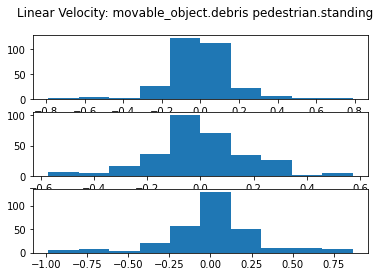

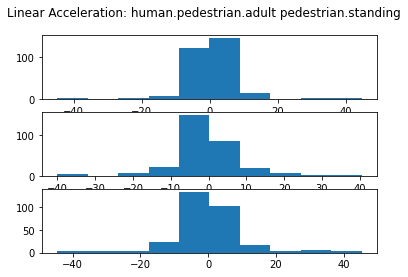

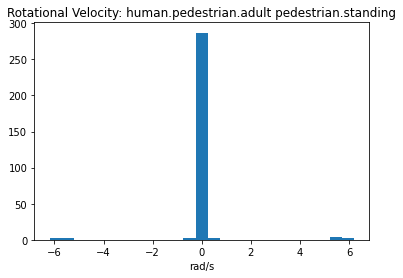

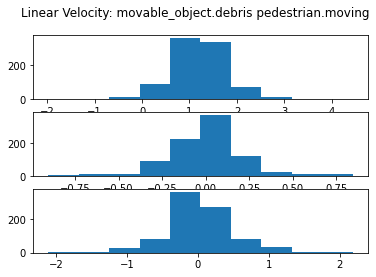

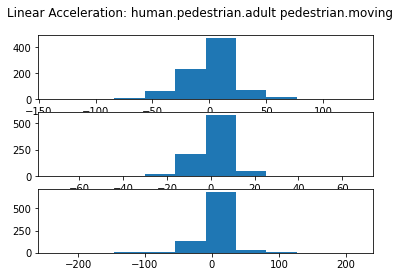

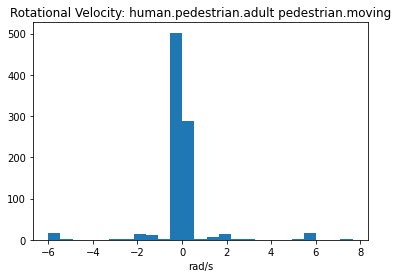

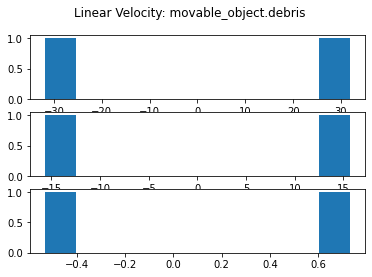

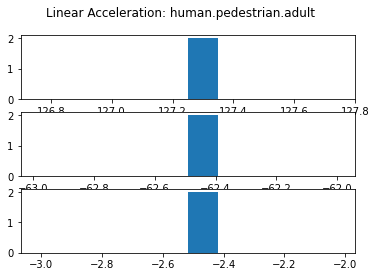

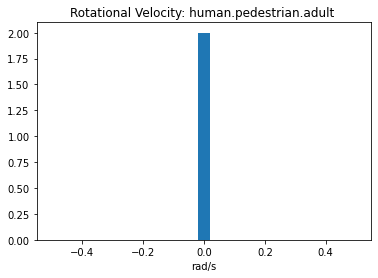

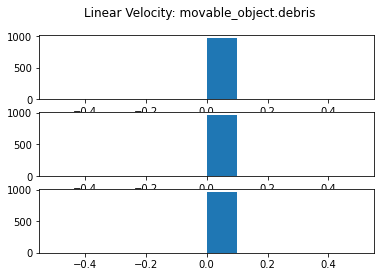

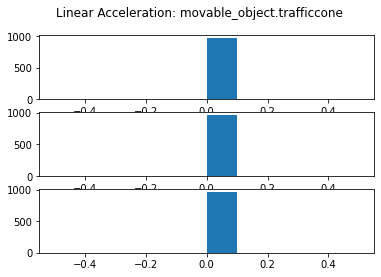

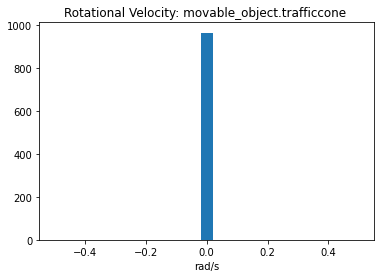

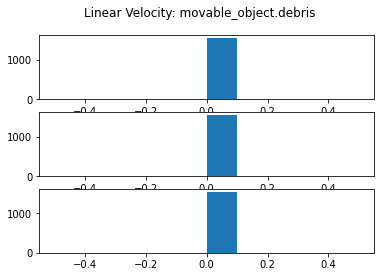

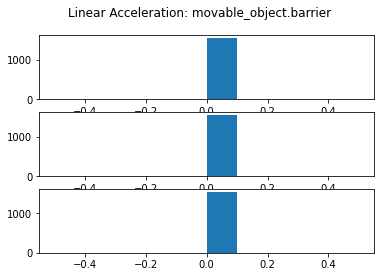

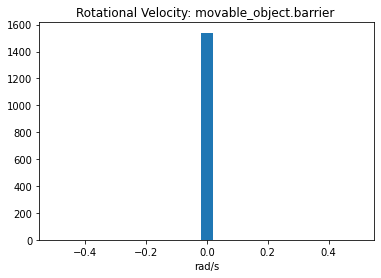

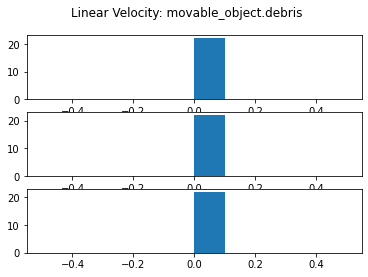

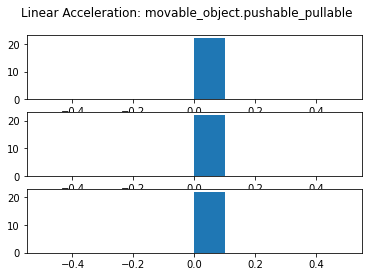

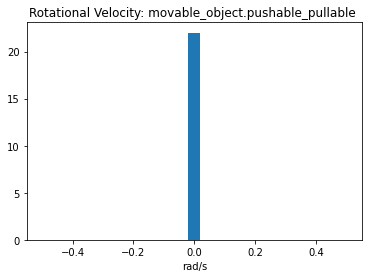

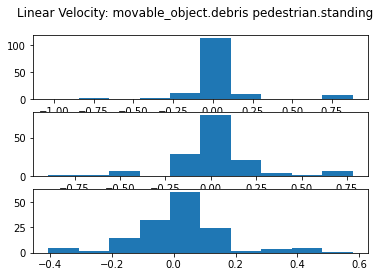

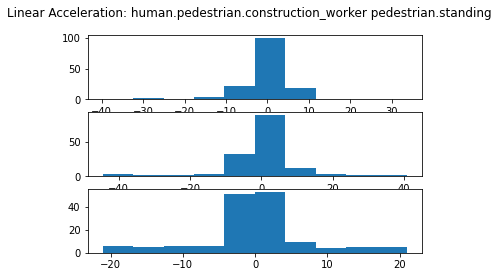

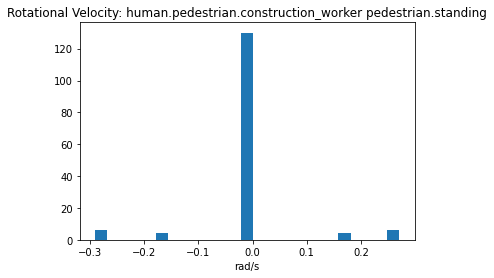

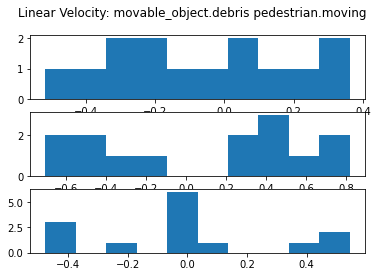

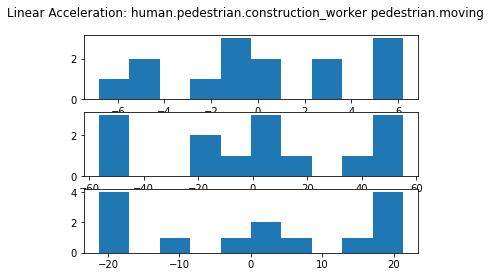

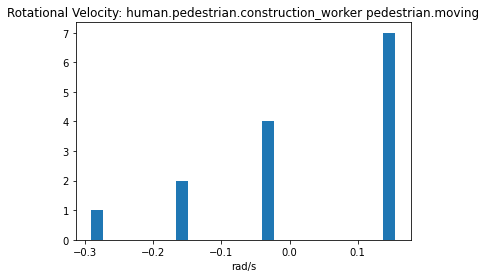

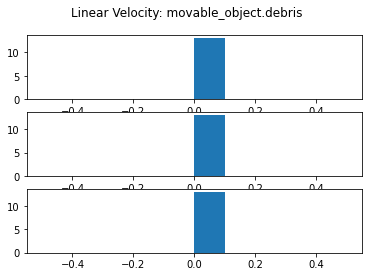

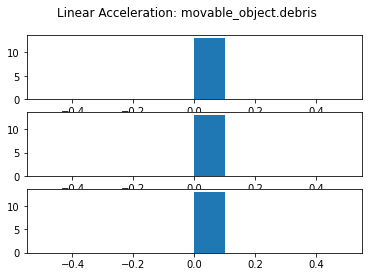

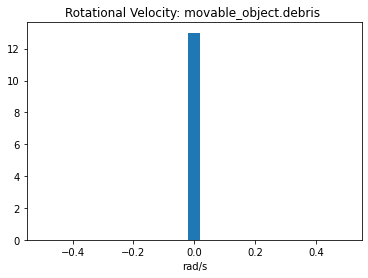

In [155]:
# TODO
# - multiple data series on same plot, with data legend/labels

def make_plots(class_att):
    
    for cls in class_att:
        for att in class_att[cls]:
    
            # make vel plot
            vel_fig, vel_axs = plt.subplots(3)
            vel_fig.suptitle('Linear Velocity: ' + str(class_type) + " " + str(att))
            vel_axs[0].hist(variable_df.loc[(variable_df['class']==cls) & (variable_df['attribute']==att),'vel_x'])
            vel_axs[1].hist(variable_df.loc[(variable_df['class']==cls) & (variable_df['attribute']==att),'vel_y'])
            vel_axs[2].hist(variable_df.loc[(variable_df['class']==cls) & (variable_df['attribute']==att),'vel_z'])

            # make acc plot
            acc_fig, acc_axs = plt.subplots(3)
            acc_fig.suptitle('Linear Acceleration: ' + str(cls) + " " + str(att))
            acc_axs[0].hist(variable_df.loc[(variable_df['class']==cls) & (variable_df['attribute']==att),'acc_x'])
            acc_axs[1].hist(variable_df.loc[(variable_df['class']==cls) & (variable_df['attribute']==att),'acc_y'])
            acc_axs[2].hist(variable_df.loc[(variable_df['class']==cls) & (variable_df['attribute']==att),'acc_z'])

            # make omega plot
            omega_fig = plt.figure("Rotational Velocity")
            plt.hist(variable_df.loc[(variable_df['class']==cls) & (variable_df['attribute']==att),'omega_z'],25)
            plt.title("Rotational Velocity: " + str(cls) + " " + str(att))
            plt.xlabel("rad/s")
            plt.show()
    
    
class_att_dict = dict()
for class_type in variable_df['class'].unique():
    print(class_type)
    
#     for att in variable_df.loc[variable_df['class']==class_type,'attribute'].unique():
#         print(att)
    class_att_dict[class_type] = list(variable_df.loc[variable_df['class']==class_type,'attribute'].unique())
    
print(class_att_dict)
make_plots(class_att_dict)
    

In [5]:
import numpy as np
import gtsam

print(gtsam.Point3(1,1,1))
print(np.array([1.]))

[1. 1. 1.]
[1.]


# Future work

In [ ]:
# TODO - get generic rotation angles from quaternion instead of just theta